In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

In [93]:
Gr = 4
Num = 7
N = 16

In [94]:
t = np.linspace(0, np.pi, N)
s = t * (Num + t) ** 0.5
p = np.piecewise(
    t,
    [t <= np.pi / 2, t > np.pi / 2], 
    [
        lambda t: np.cos(2 * (Gr * t + Num)), 
        lambda t: np.cos(Gr * t + Num)
    ],
)
r = np.random.uniform(-0.5, 0.5, N)
n = np.zeros(N)
n[5] = -8

In [95]:
f = s + p + r + n

In [96]:
def zero_small_coeffs(coeffs, threshold):
    new_coeffs = np.where(np.abs(coeffs) < threshold, 0, coeffs)
    nonzero_count = np.count_nonzero(new_coeffs)
    return new_coeffs, nonzero_count

def plot_signals(original, reconstructed, title):
    plt.figure(figsize=(10, 6))
    plt.plot(t, original, label='Оригинальный сигнал', linewidth=2)
    plt.plot(t, reconstructed, label='Восстановленный сигнал', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('t')
    plt.ylabel('Амплитуда')
    plt.legend()
    plt.grid()
    plt.show()

In [97]:
wavelet = 'db4'
wp = pywt.WaveletPacket(data=f, wavelet=wavelet, mode='symmetric', maxlevel=4)

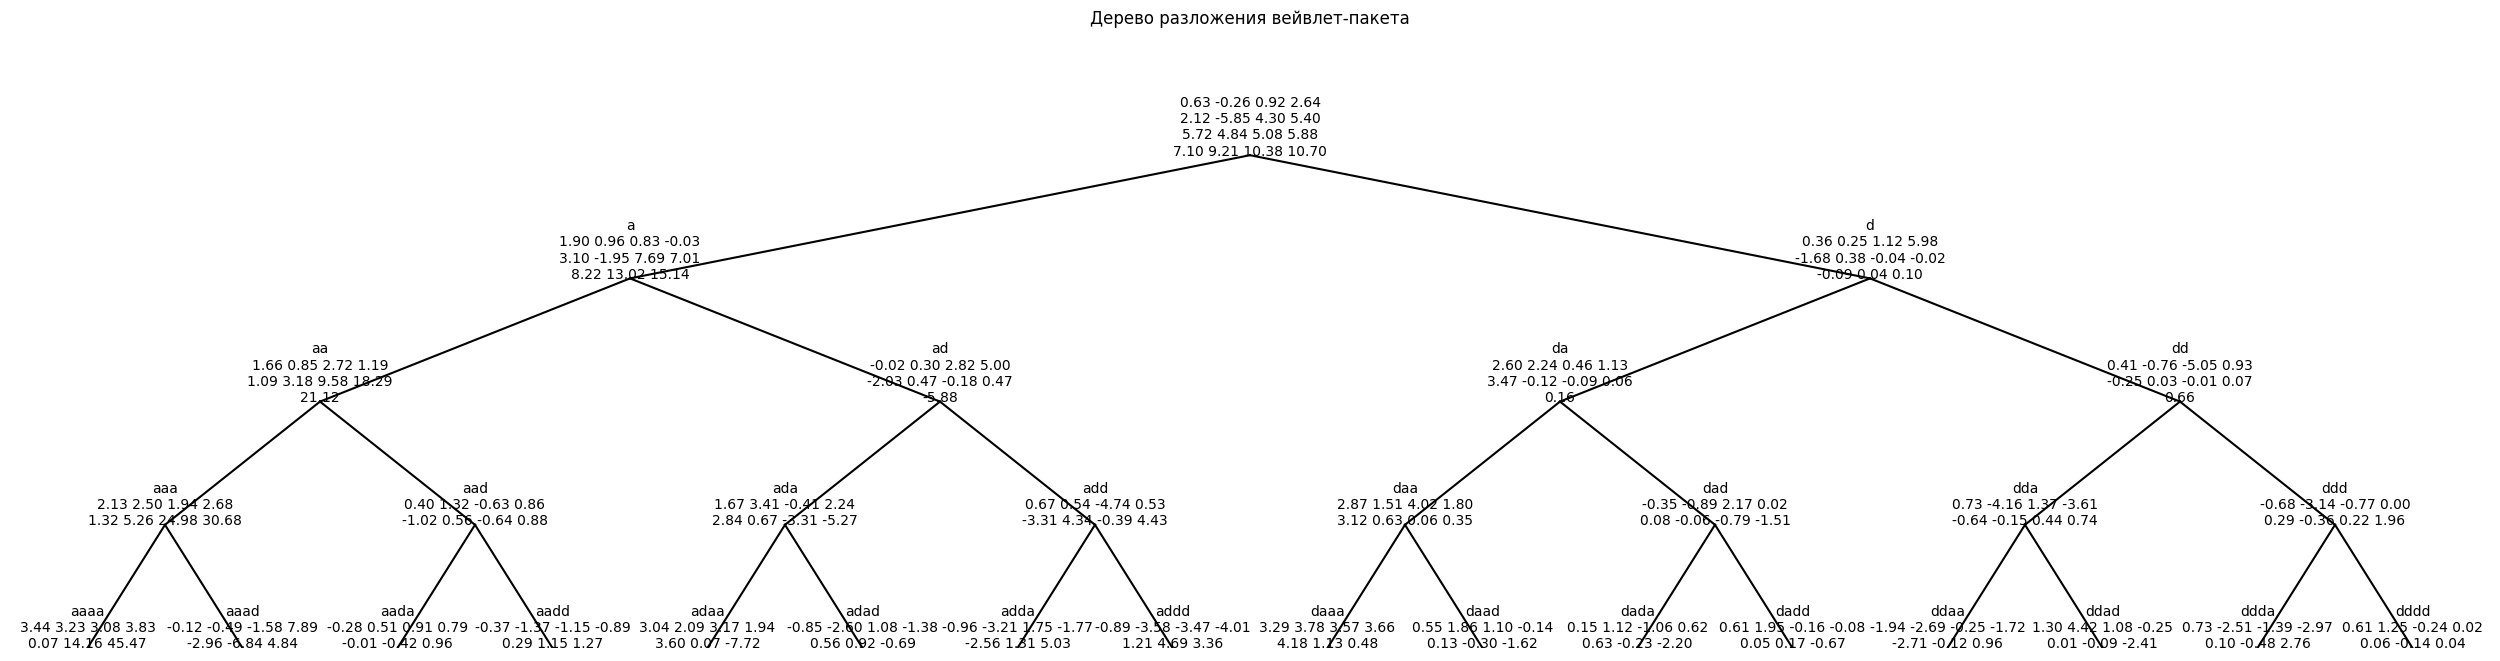

In [98]:
def plot_wp_tree(wp, maxlevel):
    def plot_node(ax, node, x, y, dx):
        text = node.path
        items = [f'{item:0.2f}' for item in node.data.round(2)]
        items = [' '.join(x for x in items[i:i+4]) for i in range(0, len(items), 4)]
        text += '\n' + '\n'.join(items)
        ax.text(x, y, text, ha='center')
        if node.level < maxlevel:
            left_x = x - dx / 2
            right_x = x + dx / 2
            ax.plot([x, left_x], [y, y - 1], 'k-')
            ax.plot([x, right_x], [y, y - 1], 'k-')
            plot_node(ax, node['a'], left_x, y - 1, dx / 2)
            plot_node(ax, node['d'], right_x, y - 1, dx / 2)
    
    fig, ax = plt.subplots(figsize=(32, 8))
    plot_node(ax, wp[''], 0, 0, 2**maxlevel)
    ax.set_xlim(-2**maxlevel, 2**maxlevel)
    ax.set_ylim(-maxlevel, 1)
    ax.axis('off')
    plt.title("Дерево разложения вейвлет-пакета")
    plt.show()

plot_wp_tree(wp, maxlevel=4)

In [99]:
wp = pywt.WaveletPacket(data=f, wavelet=wavelet, mode='symmetric', maxlevel=4)
coeffs_4 = [node.data for node in wp.get_level(4, 'natural')]
coeffs_4, nonzero_4 = zero_small_coeffs(coeffs_4, threshold=0.4)

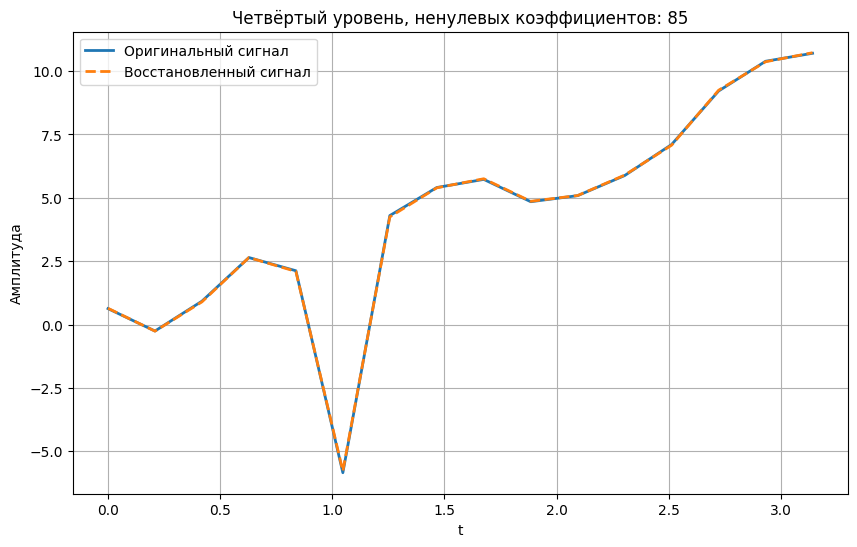

In [100]:
for i, node in enumerate(wp.get_level(4, 'natural')):
    wp[node.path].data = coeffs_4[i]
reconstructed_4 = wp.reconstruct(update=False)

plot_signals(f, reconstructed_4, f"Четвёртый уровень, ненулевых коэффициентов: {nonzero_4}")

In [101]:
wp = pywt.WaveletPacket(data=f, wavelet=wavelet, mode='symmetric', maxlevel=4)
coeffs_3 = [node.data for node in wp.get_level(3, 'natural')]
coeffs_3, nonzero_3 = zero_small_coeffs(coeffs_3, threshold=0.4)

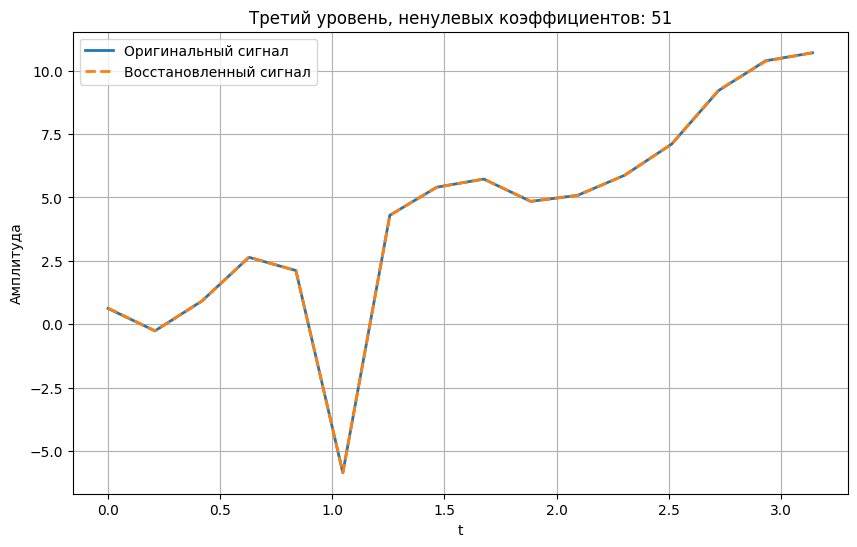

In [102]:
new_wp = pywt.WaveletPacket(data=None, wavelet=wavelet, mode='symmetric', maxlevel=4)
for i, node in enumerate(wp.get_level(3)):
    new_wp[node.path] = coeffs_3[i]
reconstructed_3 = new_wp.reconstruct(update=False)
reconstructed_3 = reconstructed_3[:len(t)]
plot_signals(f, reconstructed_3, f"Третий уровень, ненулевых коэффициентов: {nonzero_3}")


In [103]:
coeffs_2 = [node.data for node in wp.get_level(2, 'natural')]
coeffs_2, nonzero_2 = zero_small_coeffs(coeffs_2, threshold=0.4)

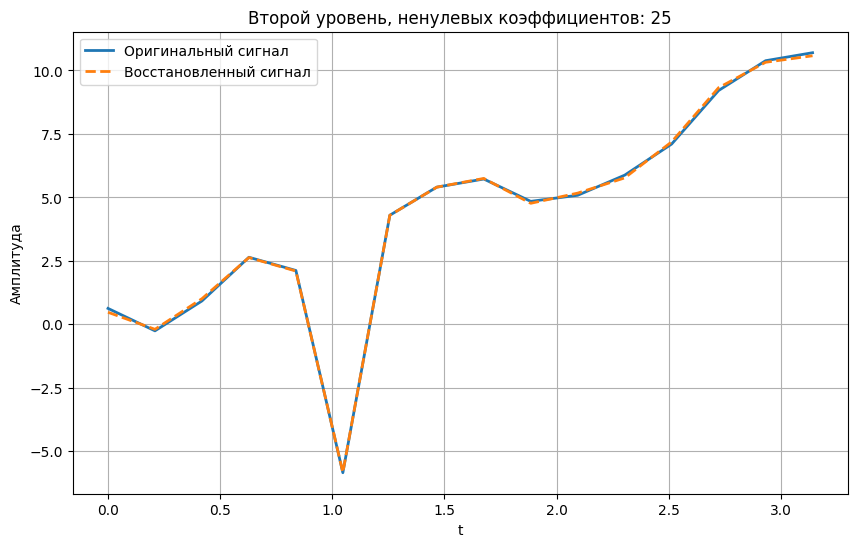

In [104]:
new_wp = pywt.WaveletPacket(data=None, wavelet=wavelet, mode='symmetric', maxlevel=4)
for i, node in enumerate(wp.get_level(2)):
    new_wp[node.path] = coeffs_2[i]
reconstructed_2 = new_wp.reconstruct(update=False)
reconstructed_2 = reconstructed_2[:len(t)]

plot_signals(f, reconstructed_2, f"Второй уровень, ненулевых коэффициентов: {nonzero_2}")


In [105]:
coeffs_1 = [node.data for node in wp.get_level(1, 'natural')]
coeffs_1, nonzero_1 = zero_small_coeffs(coeffs_1, threshold=0.4)

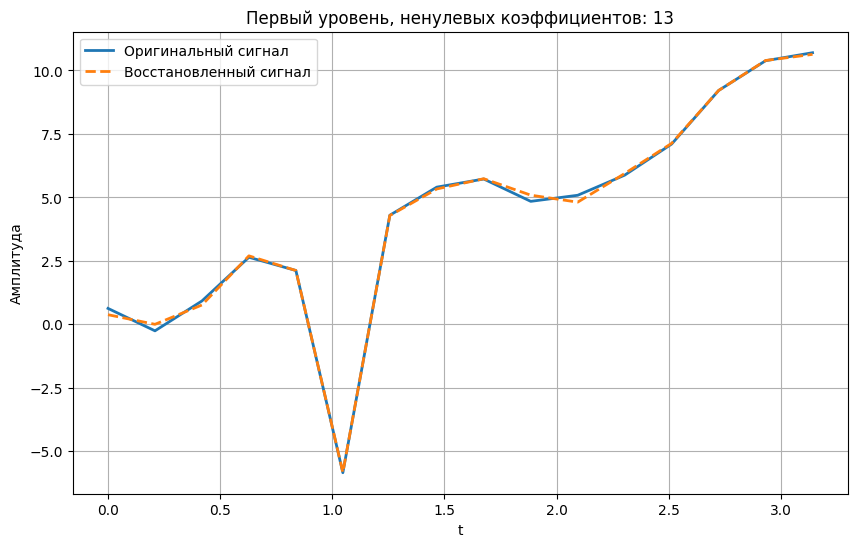

In [106]:
new_wp = pywt.WaveletPacket(data=None, wavelet=wavelet, mode='symmetric')
for i, node in enumerate(wp.get_level(1)):
    new_wp[node.path] = coeffs_1[i]
reconstructed_1 = new_wp.reconstruct(update=False)
reconstructed_1 = reconstructed_1[:len(t)]

plot_signals(f, reconstructed_1, f"Первый уровень, ненулевых коэффициентов: {nonzero_1}")


In [107]:
print(f"Число ненулевых коэффициентов:")
print(f"1 уровень: {nonzero_1}, 2 уровень: {nonzero_2}, 3 уровень: {nonzero_3}, 4 уровень: {nonzero_4}")

best_level = min([(1, nonzero_1), (2, nonzero_2), (3, nonzero_3), (4, nonzero_4)], key=lambda x: x[1])
print(f"Лучший уровень разложения: {best_level[0]} с {best_level[1]} ненулевыми коэффициентами")


Число ненулевых коэффициентов:
1 уровень: 13, 2 уровень: 25, 3 уровень: 51, 4 уровень: 85
Лучший уровень разложения: 1 с 13 ненулевыми коэффициентами


In [108]:
def print_zeros_tree(wp: pywt.WaveletPacket, threshold=0.4, level=0):
    size = 144

    for level in range(wp.maxlevel + 1):
        res = 0
        print(level, end = ' ')
        for node in wp.get_level(level): # type : pywt.Node
            zeros_count = np.count_nonzero(np.where(np.abs(node.data) < threshold, 0, node.data))
            res += zeros_count
            print(f'{node.path + ":" if node.path else ""} {zeros_count}'.center(size), end='')
        size = int(size / 2)
        print(res)


In [109]:
print_zeros_tree(wp, threshold=0.4)

0                                                                        15                                                                       15
1                                  a: 10                                                                    d: 3                                  13
2                aa: 9                               ad: 6                               da: 5                               dd: 5                25
3       aaa: 8            aad: 7            ada: 8            add: 7            daa: 6            dad: 4            dda: 7            ddd: 4      51
4  aaaa: 6  aaad: 6  aada: 5  aadd: 5  adaa: 6  adad: 7  adda: 7  addd: 7  daaa: 7  daad: 4  dada: 5  dadd: 3  ddaa: 5  ddad: 4  ddda: 6  dddd: 2 85
